In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import random
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import glob
from tqdm import tqdm

import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
MAPBOX_TOKEN = 'pk.eyJ1IjoiaWdsYXdlYiIsImEiOiJja3picmk5NmsyaDZxMndtenYyOWhvNmtnIn0.Dxi29pChSrUbePq_oZ1rTw'
px.set_mapbox_access_token(MAPBOX_TOKEN)

### Trianing period 2013-2020

We zoomed in Australia and used aggressive aggregation for a simple baseline prediction model.
* Temporal resolution: Monthly
* Spatial resolution: 1 Decimal degree ~ 10 km grid
* Binary Target: At least two fire readings

In [3]:
WORK_DIR = './wildfiredataset'

In [4]:
aus_fires = pd.read_csv(WORK_DIR + '/aus_fires_binned_geometry_new.csv')
aus_fires.shape
aus_fires.head()

(4576014, 15)

,latitude,longitude,year,month,fire_cnt,fire,fire_cnt_before,fire_before,fire_cnt_last_year,fire_last_year,fire_cnt_last_year_same_month,fire_last_year_same_month,st_bin,near_st_lat,near_st_lng
0,-40.0,143.9,2014,5,2,1,0.166667,0.083333,0.333333,0.083333,0,0,"23,46",-39.88,143.88
1,-40.0,143.9,2015,6,2,1,0.166667,0.083333,0.166667,0.083333,0,0,"23,46",-39.88,143.88
2,-40.0,143.9,2016,10,3,1,0.250000,0.083333,0.166667,0.083333,0,0,"23,46",-39.88,143.88
3,-40.0,143.9,2018,10,1,0,0.083333,0.000000,0.000000,0.000000,0,0,"23,46",-39.88,143.88
4,-40.0,143.9,2020,6,1,0,0.083333,0.000000,0.000000,0.000000,0,0,"23,46",-39.88,143.88


In [5]:
X = aus_fires

X.head()
X.shape
X.groupby('year').count()

,latitude,longitude,year,month,fire_cnt,fire,fire_cnt_before,fire_before,fire_cnt_last_year,fire_last_year,fire_cnt_last_year_same_month,fire_last_year_same_month,st_bin,near_st_lat,near_st_lng
0,-40.0,143.9,2014,5,2,1,0.166667,0.083333,0.333333,0.083333,0,0,"23,46",-39.88,143.88
1,-40.0,143.9,2015,6,2,1,0.166667,0.083333,0.166667,0.083333,0,0,"23,46",-39.88,143.88
2,-40.0,143.9,2016,10,3,1,0.250000,0.083333,0.166667,0.083333,0,0,"23,46",-39.88,143.88
3,-40.0,143.9,2018,10,1,0,0.083333,0.000000,0.000000,0.000000,0,0,"23,46",-39.88,143.88
4,-40.0,143.9,2020,6,1,0,0.083333,0.000000,0.000000,0.000000,0,0,"23,46",-39.88,143.88


(4576014, 15)

,latitude,longitude,month,fire_cnt,fire,fire_cnt_before,fire_before,fire_cnt_last_year,fire_last_year,fire_cnt_last_year_same_month,fire_last_year_same_month,st_bin,near_st_lat,near_st_lng
year,,,,,,,,,,,,,,
2014,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2015,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2016,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2017,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2018,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2019,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2020,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172,584172
2021,486810,486810,486810,486810,486810,486810,486810,486810,486810,486810,486810,486810,486810,486810


# Here is the weather data:

* temp: Mean temperature for the day in degrees Fahrenheit to tenths.
* max: Maximum temperature reported during the day in Fahrenheit to tenths--time of max temp report varies by country and region, so this will sometimes not be the max for the calendar day.
* min: Minimum temperature reported during the day in Fahrenheit to tenths--time of min temp report varies by country and region, so this will sometimes not be the min for the calendar day.
* stp: Mean station pressure for the day in millibars to tenths.
* slp: Mean sea level pressure for the day in millibars to tenths.
* dewp: Mean dew point for the day in degrees Fahrenheit to tenths.
* wdsp: Mean wind speed for the day in knots to tenths.
* prcp: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation--i.e., may include latter part of previous day. .00 indicates no measurable precipitation (includes a trace).
* fog: Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day

In [6]:
train = X[X.year < 2019].dropna()
valid = X[(X.year >= 2019) & (X.year < 2021)]
test = X[X.year == 2021]

### Total fire records

In [7]:
yearly_fires = aus_fires[aus_fires.year < 2021].groupby(['year', 'month']).sum().reset_index()
yearly_fires.head()

,year,month,latitude,longitude,fire_cnt,fire,fire_cnt_before,fire_before,fire_cnt_last_year,fire_last_year,fire_cnt_last_year_same_month,fire_last_year_same_month,near_st_lat,near_st_lng
0,2014,1,-1183588.6,6564693.9,34562,1665,61067.166728,3480.083385,46171.666682,2979.083381,55924,2887,-1185285.94,6564673.55
1,2014,2,-1183588.6,6564693.9,14030,843,61067.166728,3480.083385,46171.666682,2979.083381,21549,1633,-1185285.94,6564673.55
2,2014,3,-1183588.6,6564693.9,20592,2490,61067.166728,3480.083385,46171.666682,2979.083381,13305,1600,-1185285.94,6564673.55
3,2014,4,-1183588.6,6564693.9,42578,4520,61067.166728,3480.083385,46171.666682,2979.083381,52239,4487,-1185285.94,6564673.55
4,2014,5,-1183588.6,6564693.9,51480,4299,61067.166728,3480.083385,46171.666682,2979.083381,34415,3470,-1185285.94,6564673.55


In [8]:
# # how many wildfires per day
# px.bar(yearly_fires, x='day', y='fire_cnt', color='year',
#        title='Hotspot detections by Day in Australia')

In [9]:
px.bar(yearly_fires, x='month', y='fire_cnt', color='year',
       title='Hotspot detections by Month in Australia')

In [10]:
px.bar(yearly_fires, x='year', y='fire_cnt', color='month',
       title='Hotspot detections by Year in Australia')

In [11]:
geo = aus_fires.groupby(['latitude', 'longitude']).sum().reset_index()
geo.shape
geo.head()

(48681, 14)

,latitude,longitude,year,month,fire_cnt,fire,fire_cnt_before,fire_before,fire_cnt_last_year,fire_last_year,fire_cnt_last_year_same_month,fire_last_year_same_month,near_st_lat,near_st_lng
0,-40.0,143.9,189638,601,9,3,9.0,3.0,12.833334,4.0,13,4,-3748.72,13524.72
1,-40.0,144.0,189638,601,12,3,12.0,3.0,13.000000,3.0,13,3,-3748.72,13524.72
2,-40.0,144.1,189638,601,3,0,3.0,0.0,5.000000,1.0,5,1,-3748.72,13524.72
3,-40.0,147.9,189638,601,1,0,1.0,0.0,0.000000,0.0,0,0,-3677.28,13763.48
4,-40.0,148.0,189638,601,10,2,10.0,2.0,10.000000,2.0,10,2,-3677.28,13763.48


In [12]:
fig = ff.create_hexbin_mapbox(
    data_frame=geo, lat="latitude", lon="longitude",
    nx_hexagon=50, opacity=0.9, labels={"color": "Hotspot records"},
    color="fire_cnt", agg_func=np.sum, color_continuous_scale="Reds"
)
fig.show()

## Weather data

In [13]:
aus_weather = pd.read_csv(WORK_DIR + '/aus_weather_binned_new.csv')
aus_weather.shape
aus_weather.head()

(42012, 12)

,STATION,LATITUDE,LONGITUDE,year,month,T_MAX,T_MAX_MEAN,T_MEAN,DEWP_MEAN,WDSP_MEAN,MXSPD_MAX,st_bin
0,94100099999,-14.3,126.63,2013,1,98.2,92.912903,83.251613,73.677419,4.151613,15.9,"4,21"
1,94100099999,-14.3,126.63,2019,7,94.1,90.822581,73.174194,47.225806,4.209677,14.0,"4,21"
2,94100099999,-14.3,126.63,2019,6,95.0,88.550000,73.200000,45.390000,4.240000,12.0,"4,21"
3,94100099999,-14.3,126.63,2019,5,98.8,92.212903,76.674194,55.309677,4.029032,13.0,"4,21"
4,94100099999,-14.3,126.63,2019,4,97.5,93.663333,81.046667,67.276667,3.376667,15.0,"4,21"


In [14]:
print('Number of unique stations', len(aus_weather['STATION'].unique()))

Number of unique stations 389


In [15]:
# remove duplicate rows from weather dataframe
print('Before delete', aus_weather.shape)
aus_weather_f = aus_weather.drop_duplicates(subset=['LATITUDE', 'LONGITUDE'], keep='first')
print('After delete', aus_weather_f.shape)

aus_weather_f['STAT_ID'] = aus_weather_f.index + 1

Before delete (42012, 12)
After delete (389, 12)


In [16]:
import plotly.express as px
import geopandas as gpd

fig = px.scatter_geo(aus_weather_f,
                    lat=aus_weather_f.LATITUDE,
                    lon=aus_weather_f.LONGITUDE,
                    hover_name="STAT_ID")
fig.show()

In [17]:
features = [
    'latitude', 'longitude', 'month',
    'fire_cnt_before', 'fire_before',
    'fire_cnt_last_year', 'fire_last_year',
    'fire_cnt_last_year_same_month', 'fire_last_year_same_month'
]

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

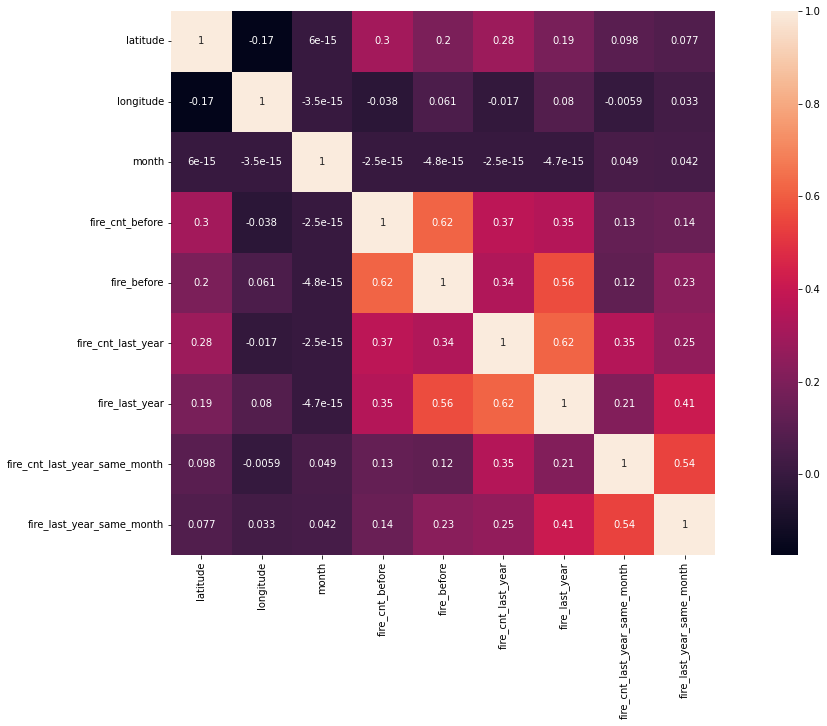

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(20,10))
sns.heatmap(train[features].corr(), annot=True, square=True)
plt.show()